In [1]:
import sys
sys.path.append("../")  # 确保根目录在 sys.path 中
from PIL import Image
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import src.postProcess as PostProcess

In [2]:
react_table3 = np.array([[[0.9, 2], [0.9, 3], [0.9, 4], [0.9, -4], [0.5, 7], [0.0, 0], [0.5, 8], [0.0, 0], [0.6, 10], [0.0, 0], [0.0, 0]],
                        [[0.5, 5], [0.0, 0], [0.0, 0], [0.0, 0], [0.5, 6], [0.0, 0], [0.0, 0], [0.0, 0], [0.0, 0], [0.0, 0], [0.0, 0]],
                        [[1, -1], [1, -2], [1, -3], [1, -4], [1, -5], [1, -6], [1, -7], [1, -8], [1, -9], [1, -10], [0.0, 0]]])

# react_table3 = np.array([[[0.1, 2], [0.1, 3], [0.1, 4], [0.1, -4], [0.5, 7], [0.0, 0], [0.5, 8], [0.0, 0], [0.6, 10], [0.0, 0]],
#                         [[0.5, 5], [0.0, 0], [0.0, 0], [0.0, 0], [0.5, 6], [0.0, 0], [0.0, 0], [0.0, 0], [0.0, 0], [0.0, 0]],
#                         [[0.27, -1], [0.27, -2], [0.27, -3], [0.27, -4], [0.27, -5], [0.27, -6], [0.27, -7], [0.27, -8], [0.27, -9], [0.27, -10]]])
color_names = ['dimgray', 'blue', 'red', 'green','cyan', 'black', 'white','yellow', 'brown', 'magenta', 'orange', 'purple', 'pink', 'gray']
labels = ['Si', 'SiF1', 'SiF2', 'SiF3', 'SiO', 'SiO2', 'SiOF', 'SiOF2', 'SiO2F', 'SiO2F2', 'mask']

# print(react_table3.shape)
# react_table = np.zeros((3, 11, 12))
react_table = np.zeros((react_table3.shape[0], react_table3.shape[1], react_table3.shape[1] + 1))

for i in range(react_table3.shape[0]):
    for j in range(react_table3.shape[1]):
        for k in range(react_table3.shape[2]):
            react_table[i, j, 0] = react_table3[i, j, 0]
            react_table[i, j, j+1] = -1
            react_chem =  int(np.abs(react_table3[i, j, 1]))
            if react_table3[i, j, 1] > 0:
                react_plus_min = 1
            elif react_table3[i, j, 1] < 0:
                react_plus_min = -1
            elif react_table3[i, j, 1] == 0:
                react_plus_min = 0
            react_table[i, j, react_chem] = react_plus_min

print(react_table)

[[[ 0.9 -1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
  [ 0.9  0.  -1.   1.   0.   0.   0.   0.   0.   0.   0.   0. ]
  [ 0.9  0.   0.  -1.   1.   0.   0.   0.   0.   0.   0.   0. ]
  [ 0.9  0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.   0. ]
  [ 0.5  0.   0.   0.   0.  -1.   0.   1.   0.   0.   0.   0. ]
  [ 0.   0.   0.   0.   0.   0.  -1.   0.   0.   0.   0.   0. ]
  [ 0.5  0.   0.   0.   0.   0.   0.  -1.   1.   0.   0.   0. ]
  [ 0.   0.   0.   0.   0.   0.   0.   0.  -1.   0.   0.   0. ]
  [ 0.6  0.   0.   0.   0.   0.   0.   0.   0.  -1.   1.   0. ]
  [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -1.   0. ]
  [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -1. ]]

 [[ 0.5 -1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0. ]
  [ 0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
  [ 0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0. ]
  [ 0.   0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.   0. ]
  [ 0.5  0.   0.   0.   0.  -1.   1.  

In [3]:
react_type_table = np.ones((4, 11), dtype=np.int32) # 1 for chemical transfer 
react_type_table[2, :] = 2 # 2 for physics
react_type_table[3, :] = 3 # 3 for redepo
react_type_table[0, 3] = 4 # 1 for chemical remove
react_type_table[2, -1] = 0 # 2 for no reaction for mask in test

print(react_type_table)

[[1 1 1 4 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2 0]
 [3 3 3 3 3 3 3 3 3 3 3]]


In [4]:
react_prob_chemical = react_table[:2, :, 0]

print(react_prob_chemical)

print(react_prob_chemical.shape)

[[0.9 0.9 0.9 0.9 0.5 0.  0.5 0.  0.6 0.  0. ]
 [0.5 0.  0.  0.  0.5 0.  0.  0.  0.  0.  0. ]]
(2, 11)


In [5]:
print(react_table.shape)

print(react_table[:, :, 1:])

(3, 11, 12)
[[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0. -1.  0.  1.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]]

 [[-1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
  [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.

In [6]:
# 读取图像为灰度模式
# image = Image.open("./hard_mask_KLA3.jpg").convert("L")
image = Image.open("./sf_o2_mask.jpg").convert("L")
# 转换为 NumPy 数组
HardMasK = np.array(image)

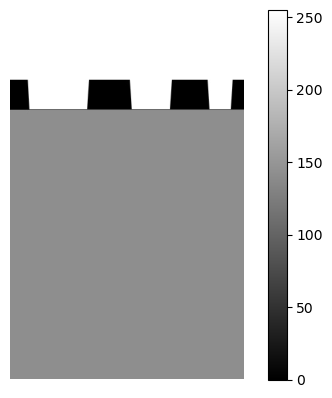

In [7]:
plt.imshow(HardMasK, cmap="gray")  # 指定灰度色彩映射
plt.colorbar()  # 显示颜色条（可选）
# plt.title("Grayscale Image")
plt.axis("off")  # 不显示坐标轴
plt.show()

In [8]:
HardMasK.shape

(591, 373)

In [9]:
# Hard mask SF6_O2
film = np.zeros((20, HardMasK.shape[1], HardMasK.shape[0], 11), dtype=np.int32)
density = 20
for i in range(HardMasK.shape[1]):
    for j in range(HardMasK.shape[0]):
        if HardMasK[j, i] >= 120 and HardMasK[j, i] < 200: # HM
            film[:, i, -j, 0] = density
        if HardMasK[j, i] < 100: # Si
            film[:, i, -j, -1] = density

film[:, :, :432, -1] = 0
film[:, :, 432:, 0] = 0
film[:, :, :432, 0] = 20
# film[:, :, 431:, 0] = 0
# film[:, :, :60, -1] = 0
film[:, :, :10, 0] = density

In [10]:
film[2, 100, 431]

array([20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [ ]:
color_names = ['dimgray', 'blue', 'red', 'green','cyan', 'black', 'white','yellow', 'brown', 'magenta', 'orange', 'purple', 'pink', 'gray']
labels = ['Si', 'SiF1', 'SiF2', 'SiF3', 'SiO', 'SiO2', 'SiOF', 'SiOF2', 'SiO2F', 'SiO2F2', 'mask']

#solid = film[i, j, k, 10][Si, SiF1, SiF2, SiF3, SiO SiO2, SiOF, SiOF2, SiO2F, SiO2F2, mask]
PostProcess.PostProcess_multiLayer(film, colors=color_names, labels=labels)

In [ ]:
film_array_bf = np.load('./film_array_bf.npy')
film_array = np.load('./film_array.npy')

In [ ]:
typeID_array_bf = np.load('./typeID_array_bf.npy')
typeID_array = np.load('./typeID_array.npy')
print(typeID_array.shape)

In [ ]:
normal_array_bf = np.load('./normal_array_bf.npy')
normal_array = np.load('./normal_array.npy')
print(normal_array.shape)

In [11]:
film_array_bf = np.load('./film_array_bf.npy')
film_array = np.load('./film_array_sfo2.npy')
typeID_array_bf = np.load('./typeID_array_bf.npy')
typeID_array = np.load('./typeID_array_sfo2.npy')
print(typeID_array.shape)
normal_array_bf = np.load('./normal_array_bf.npy')
normal_array = np.load('./normal_array_sfo2.npy')
print(normal_array.shape)

(20, 373, 591)
(20, 373, 591, 3)


In [12]:
print(film_array.shape)

(20, 373, 591, 11)


In [13]:
from numba import jit, prange

@jit(nopython=True)
def transfer_to_plane(typeID_array, normal_array):
    plane = np.zeros((typeID_array.shape[0]*typeID_array.shape[1]*typeID_array.shape[2], 6))
    count = 0
    for i in range(typeID_array.shape[0]):
        for j in range(typeID_array.shape[1]):
            for k in range(typeID_array.shape[2]):
                if typeID_array[i,j,k] == 1:
                    plane[count, :3] = normal_array[i,j,k]
                    plane[count, 3:6] = i, j, k
                    count += 1
    return plane[:count]

@jit(nopython=True)
def layerLoop(film):
    layer = np.zeros((film.shape[0],film.shape[1],film.shape[2]))
    for i in range(film.shape[0]):
        for j in range(film.shape[1]):
            for k in range(film.shape[2]):
                for c in range(film.shape[3]):
                    if np.sum(film[i, j, k]) > 0:
                        layer[i, j, k] = np.argmax(film[i, j, k]) + 1 
    return layer    

color_names = ['dimgray', 'blue', 'red', 'green','cyan', 'black', 'white','yellow', 'brown', 'magenta', 'orange', 'purple', 'pink', 'gray']
# labels = ['Si', 'SiCl1', 'SiCl2', 'SiCl3', 'mask']
color_names = ['dimgray', 'blue', 'red', 'green','cyan', 'black', 'white','yellow', 'brown', 'magenta', 'orange', 'purple', 'pink', 'gray']
labels = ['Si', 'SiF1', 'SiF2', 'SiF3', 'SiO', 'SiO2', 'SiOF', 'SiOF2', 'SiO2F', 'SiO2F2', 'mask']
geom = pv.Box()
p = pv.Plotter()

layer =layerLoop(film_array)

for ci in range(film_array.shape[3]):
    layerCube = np.argwhere(layer == ci+1)
    if layerCube.size != 0:
        layermesh = pv.PolyData(layerCube)
        layermesh["radius"] = np.ones(layerCube.shape[0])*0.5
        layerglyphed = layermesh.glyph(scale="radius", geom=geom, orient=False) # progress_bar=True)
        p.add_mesh(layerglyphed, color=color_names[ci], label=labels[ci],opacity=0.7)

plane = transfer_to_plane(typeID_array, normal_array)

point_cloud = pv.PolyData(plane[:, 3:6])
vectors = plane[:, :3]

point_cloud['vectors'] = vectors
arrows = point_cloud.glyph(
    orient='vectors',
    scale=1000,
    factor=3,
)

p.add_mesh(point_cloud, color='cyan', point_size=5.0, render_points_as_spheres=True)
p.add_mesh(arrows, color='lightblue', opacity= 0.1)

p.enable_eye_dome_lighting()
p.add_legend()
p.show()

/home/ysy/.local/lib/python3.10/site-packages/pyvista/core/utilities/points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value='<iframe src="http://localhost:37341/index.html?ui=P_0x7f2f852f0af0_0&reconnect=auto" class="pyvi…

In [ ]:
color_names = ['dimgray', 'blue', 'red', 'green','cyan', 'black', 'white','yellow', 'brown', 'magenta', 'orange', 'purple', 'pink', 'gray']
labels = ['Si', 'SiCl1', 'SiCl2', 'SiCl3', 'mask']
PostProcess.PostProcess_multiLayer(film_array, colors=color_names, labels=labels)

In [ ]:
# Hard mask
film = np.zeros((20, HardMasK.shape[1], HardMasK.shape[0], 5), dtype=np.int32)
density = 20
for i in range(HardMasK.shape[1]):
    for j in range(HardMasK.shape[0]):
        if HardMasK[j, i] < 80: # Si
            film[:, i, -j, 0] = density
        if HardMasK[j, i] >= 80 and HardMasK[j, i] < 120: # HM
            film[:, i, -j, -1] = density

film[:, :, :450, -1] = 0
# film[:, :, :60, -1] = 0
film[:, :, :2, -1] = density

In [ ]:
Cell_dtype = np.dtype([
    ('id', np.int32),
    ('index', np.int32, (3,)),
    ('film', np.int32, (5,)),
    ('normal', np.float64, (3,))
], align=True)  # 添加 align=True

cell = np.zeros((20, HardMasK.shape[1], HardMasK.shape[0]), dtype=Cell_dtype)

cell['film'] = film

In [ ]:
cell[10, 10:15, 10]['film']

In [ ]:
def scanZ_numpy_bool(film):
    # 初始化一个全零的表面数组
    surface_sparse_depo = np.zeros_like(film, dtype=np.bool_)

    # depo 条件
    current_plane = film != 0

    # 创建邻居布尔索引数组
    neighbors = np.zeros_like(film, dtype=bool)

    # 获取周围邻居的布尔索引
    neighbors[1:, :, :] |= film[:-1, :, :] == 0  # 上面
    neighbors[:-1, :, :] |= film[1:, :, :] == 0  # 下面
    neighbors[:, 1:, :] |= film[:, :-1, :] == 0  # 左边
    neighbors[:, :-1, :] |= film[:, 1:, :] == 0  # 右边
    neighbors[:, :, 1:] |= film[:, :, :-1] == 0  # 前面
    neighbors[:, :, :-1] |= film[:, :, 1:] == 0  # 后面

    # 获取满足条件的索引
    condition_depo = current_plane & neighbors

    # 更新表面稀疏张量
    surface_sparse_depo[condition_depo] = True

    return surface_sparse_depo

def scanZ_vacuum_numpy_bool(film):
    # 初始化一个全零的表面数组
    surface_sparse_depo = np.zeros_like(film, dtype=np.bool_)

    # depo 条件
    current_plane = film == 0

    # 创建邻居布尔索引数组
    neighbors = np.zeros_like(film, dtype=bool)

    # 获取周围邻居的布尔索引
    neighbors[1:, :, :] |= film[:-1, :, :] > 0  # 上面
    neighbors[:-1, :, :] |= film[1:, :, :] > 0  # 下面
    neighbors[:, 1:, :] |= film[:, :-1, :] > 0  # 左边
    neighbors[:, :-1, :] |= film[:, 1:, :] > 0  # 右边
    neighbors[:, :, 1:] |= film[:, :, :-1] > 0  # 前面
    neighbors[:, :, :-1] |= film[:, :, 1:] > 0  # 后面

    # 获取满足条件的索引
    condition_depo = current_plane & neighbors

    # 更新表面稀疏张量
    surface_sparse_depo[condition_depo] = True

    return surface_sparse_depo

def scanZ_underSurface_bool(film):
    # 初始化一个全零的表面数组
    surface_sparse_depo = np.zeros_like(film, dtype=np.bool_)

    # depo 条件
    current_plane = film == 3

    # 创建邻居布尔索引数组
    neighbors = np.zeros_like(film, dtype=bool)

    # 获取周围邻居的布尔索引
    neighbors[1:, :, :] |= film[:-1, :, :] == 1  # 上面
    neighbors[:-1, :, :] |= film[1:, :, :] == 1  # 下面
    neighbors[:, 1:, :] |= film[:, :-1, :] == 1  # 左边
    neighbors[:, :-1, :] |= film[:, 1:, :] == 1  # 右边
    neighbors[:, :, 1:] |= film[:, :, :-1] == 1  # 前面
    neighbors[:, :, :-1] |= film[:, :, 1:] == 1  # 后面

    # 获取满足条件的索引
    condition_depo = current_plane & neighbors

    # 更新表面稀疏张量
    surface_sparse_depo[condition_depo] = True

    return surface_sparse_depo

def get_normal_from_index( film_label_index_normal_mirror, film_label_index_normal, mirrorGap, point):
    x, y, z = point
    x += mirrorGap
    y += mirrorGap
    grid_cube = film_label_index_normal_mirror[x-3:x+4, y-3:y+4, z-3:z+4]

    plane_bool = grid_cube[:, :, :, 0] == 1
    positions = grid_cube[plane_bool][:, 1:4]

    xmn = np.mean(positions[:, 0])
    ymn = np.mean(positions[:, 1])
    zmn = np.mean(positions[:, 2])
    c = positions - np.stack([xmn, ymn, zmn])
    cov = np.dot(c.T, c)

    # SVD 分解协方差矩阵
    u, s, vh = np.linalg.svd(cov)

    # 最小特征值对应的特征向量
    normal = u[:, -1]  # 最小特征值的特征向量是最后一列

    x -= mirrorGap
    y -= mirrorGap
    film_label_index_normal[x, y, z, -3:] = normal
    return film_label_index_normal

def update_surface_mirror(surface_etching,surface_etching_mirror, mirrorGap, cellSizeX, cellSizeY):
    surface_etching_mirror[mirrorGap:mirrorGap+cellSizeX, mirrorGap:mirrorGap+cellSizeY, :] = surface_etching
    surface_etching_mirror[:mirrorGap, mirrorGap:mirrorGap+cellSizeY, :] = surface_etching[-mirrorGap:, :, :]
    surface_etching_mirror[-mirrorGap:, mirrorGap:mirrorGap+cellSizeY, :] = surface_etching[:mirrorGap, :, :]
    surface_etching_mirror[mirrorGap:mirrorGap+cellSizeX, :mirrorGap, :] = surface_etching[:, -mirrorGap:, :]
    surface_etching_mirror[mirrorGap:mirrorGap+cellSizeX:, -mirrorGap:, :] = surface_etching[:, :mirrorGap, :]
    surface_etching_mirror[:mirrorGap, :mirrorGap, :] = surface_etching[-mirrorGap:, -mirrorGap:, :]
    surface_etching_mirror[:mirrorGap, -mirrorGap:, :] = surface_etching[-mirrorGap:, :mirrorGap, :]
    surface_etching_mirror[-mirrorGap:, :mirrorGap, :] = surface_etching[:mirrorGap, -mirrorGap:, :]
    surface_etching_mirror[-mirrorGap:, -mirrorGap:, :] = surface_etching[:mirrorGap, :mirrorGap, :]
    
    return surface_etching_mirror

def build_film_label_index_normal( sumfilm, mirrorGap):
    surface_film = scanZ_numpy_bool(sumfilm)
    vacuum_film = scanZ_vacuum_numpy_bool(sumfilm)

    film_label = np.zeros_like(sumfilm)

    solid_mask = sumfilm != 0
    film_label[solid_mask] = 3
    film_label[surface_film] = 1
    undersurface_film = scanZ_underSurface_bool(film_label)
    film_label[undersurface_film] = 2
    film_label[vacuum_film] = -1

    film_label_index_normal = np.zeros((film_label.shape[0], film_label.shape[1], film_label.shape[2], 7))

    for i in range(film_label_index_normal.shape[0]):
        for j in range(film_label_index_normal.shape[1]):
            for k in range(film_label_index_normal.shape[2]):
                film_label_index_normal[i, j, k, 0] = film_label[i, j, k]
                film_label_index_normal[i, j, k, 1] = i
                film_label_index_normal[i, j, k, 2] = j
                film_label_index_normal[i, j, k, 3] = k

    cellSizeX, cellSizeY, cellSizeZ = sumfilm.shape
    film_label_index_normal_mirror = np.zeros((cellSizeX+int(mirrorGap*2), cellSizeY+int(mirrorGap*2), cellSizeZ, 7))
    film_label_index_normal_mirror = update_surface_mirror(film_label_index_normal, film_label_index_normal_mirror, mirrorGap, cellSizeX, cellSizeY)

    surface_point = np.array(np.where(film_label_index_normal[:, :, :, 0] == 1)).T

    print(surface_point.shape)
    for i in range(surface_point.shape[0]):
        # print(surface_point[i])
        film_label_index_normal = get_normal_from_index(film_label_index_normal_mirror, film_label_index_normal, mirrorGap, surface_point[i])
    return film_label_index_normal

In [ ]:
sumFilm = np.sum(film, axis=-1)
mirrorGap = 3
cellSizeX, cellSizeY, cellSizeZ = sumFilm.shape
film_label_index_normal = build_film_label_index_normal(sumFilm, mirrorGap)
film_label_index_normal_mirror = np.zeros((cellSizeX+int(mirrorGap*2), cellSizeY+int(mirrorGap*2), cellSizeZ, 7))
film_label_index_normal_mirror = update_surface_mirror(film_label_index_normal, film_label_index_normal_mirror, mirrorGap, cellSizeX, cellSizeY)


In [ ]:
film_mirror = np.zeros((film.shape[0]+int(mirrorGap*2), film.shape[1]+int(mirrorGap*2), film.shape[2], film.shape[3]))
film_mirror= update_surface_mirror(film, film_mirror, mirrorGap, cellSizeX, cellSizeY)

In [ ]:
cell = np.zeros((film_label_index_normal_mirror.shape[0], 
                 film_label_index_normal_mirror.shape[1], 
                 film_label_index_normal_mirror.shape[2]), dtype=Cell_dtype)

cell['id'] = film_label_index_normal_mirror[:,:,:,0]
cell['normal'] = film_label_index_normal_mirror[:,:,:,-3:]
cell['film'] = film_mirror
cell['index'] = film_label_index_normal_mirror[:,:,:,1:4]

In [ ]:
from numba import jit, prange

@jit(nopython=True)
def transfer_to_plane(film_label_index_normal):
    plane = np.zeros((film_label_index_normal.shape[0]*film_label_index_normal.shape[1]*film_label_index_normal.shape[2], 6))
    count = 0
    for i in range(film_label_index_normal.shape[0]):
        for j in range(film_label_index_normal.shape[1]):
            for k in range(film_label_index_normal.shape[2]):
                if film_label_index_normal[i,j,k]['id'] == 1:
                    plane[count, :3] = film_label_index_normal[i,j,k]['normal']
                    plane[count, 3:6] = i, j, k
                    count += 1
    return plane[:count]

@jit(nopython=True)
def layerLoop(film):
    layer = np.zeros((film.shape[0],film.shape[1],film.shape[2]))
    for i in range(film.shape[0]):
        for j in range(film.shape[1]):
            for k in range(film.shape[2]):
                for c in range(film.shape[3]):
                    if np.sum(film[i, j, k]) > 0:
                        layer[i, j, k] = np.argmax(film[i, j, k]) + 1 
    return layer    

color_names = ['dimgray', 'blue', 'red', 'green','cyan', 'black', 'white','yellow', 'brown', 'magenta', 'orange', 'purple', 'pink', 'gray']
labels = ['Si', 'SiCl1', 'SiCl2', 'SiCl3', 'mask']

geom = pv.Box()
p = pv.Plotter()

layer =layerLoop(cell['film'])

for ci in range(cell['film'].shape[3]):
    layerCube = np.argwhere(layer == ci+1)
    if layerCube.size != 0:
        layermesh = pv.PolyData(layerCube)
        layermesh["radius"] = np.ones(layerCube.shape[0])*0.5
        layerglyphed = layermesh.glyph(scale="radius", geom=geom, orient=False) # progress_bar=True)
        p.add_mesh(layerglyphed, color=color_names[ci], label=labels[ci],opacity=0.7)

plane = transfer_to_plane(cell)

point_cloud = pv.PolyData(plane[:, 3:6])
vectors = plane[:, :3]

point_cloud['vectors'] = vectors
arrows = point_cloud.glyph(
    orient='vectors',
    scale=10000,
    factor=3,
)

p.add_mesh(point_cloud, color='cyan', point_size=5.0, render_points_as_spheres=True)
p.add_mesh(arrows, color='lightblue', opacity= 0.1)

p.enable_eye_dome_lighting()
p.add_legend()
p.show()

In [ ]:
color_names = ['dimgray', 'blue', 'red', 'green','cyan', 'black', 'white','yellow', 'brown', 'magenta', 'orange', 'purple', 'pink', 'gray']
labels = ['Si', 'SiCl1', 'SiCl2', 'SiCl3', 'mask']
PostProcess.PostProcess_multiLayer(cell['film'], colors=color_names, labels=labels)

In [ ]:
import react

In [ ]:
react.inputCell(cell)